103500


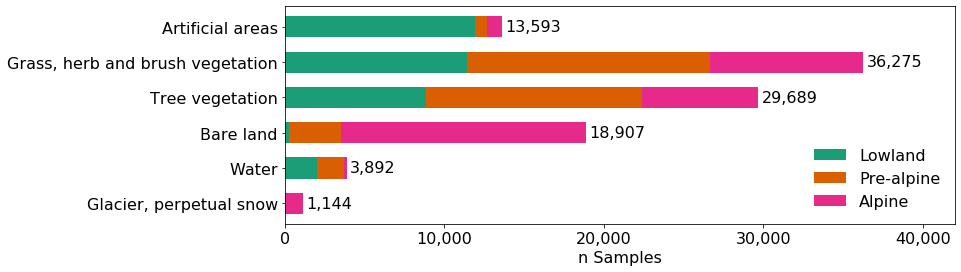

In [23]:
"""
Script to create a plot that summarizes the reference data
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

label = 'land_cover'
rois = ['roi1','roi2','roi3']
yearAS = 2004

df = pd.read_csv(f'data/arealstatistik/as{yearAS}_preprocessed.csv')
print(df.shape[0])

stats = df.groupby(['roi', label]).size()
classes = sorted(df[label].unique())
class_names = [
    'Artificial areas',
    'Grass, herb and brush vegetation',
    'Tree vegetation',
    'Bare land',
    'Water',
    'Glacier, perpetual snow'
]

class_names.reverse()

xs = [stats[roi].index.tolist() for roi in rois]
ys = [stats[roi].tolist() for roi in rois]

# adding classes that are not present
new_ys = []
for iroi in range(len(rois)):
    y = []
    for iclass in classes:
        if iclass in xs[iroi]:
            y.append(ys[iroi][xs[iroi].index(iclass)])
        else:
            y.append(0)
    y.reverse()
    new_ys.append(np.array(y))
ys = new_ys


fontsize = 16

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(12)
plt.rcParams.update({'font.size': fontsize, 'axes.labelsize': fontsize, 'axes.titlesize': fontsize })

# stack bars
bar_width = 0.6
ax.barh(class_names, ys[0], label='Lowland', color='#1b9e77', height=bar_width)
ax.barh(class_names, ys[1], left=ys[0], label='Pre-alpine', color='#d95f02', height=bar_width)
ax.barh(class_names, ys[2], left=ys[0]+ys[1], label='Alpine', color='#e7298a', height=bar_width)

for xpos, ypos in zip(classes, ys[0]+ys[1]+ys[2]):
    ax.text(ypos+200, xpos, f'{ypos:,}', va='center')

ax.set_xlim([0,42000])
xticks = range(0,40001,10000)
ax.set_xticks(xticks)
ax.set_xticklabels([f'{xtick:,}' for xtick in xticks],fontsize=fontsize)
ax.set_yticklabels(class_names,fontsize=fontsize)
ax.set_xlabel('n Samples',fontweight='normal')
plt.legend(loc='lower right', frameon=False)
plt.savefig(f'plots/overview_reference_data_as{yearAS}.png', dpi=300, bbox_inches = "tight")
plt.show()    

In [12]:
"""
Script to analyse the spectral signature of the reference data
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline



spectral_bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
rois = ['roi1','roi2','roi3']
label = 'land_cover'
yearAS = 2004
path = 'data/classification_data/'

df_coefs = pd.read_csv(f'{path}coefficients_labeled_as{yearAS}.csv')

df_coefs.head()

,roi,X,Y,land_cover,topleft_blue_c,topleft_blue_a1,topleft_blue_b1,topleft_green_c,topleft_green_a1,topleft_green_b1,...,lowerright_red_b1,lowerright_nir_c,lowerright_nir_a1,lowerright_nir_b1,lowerright_swir1_c,lowerright_swir1_a1,lowerright_swir1_b1,lowerright_swir2_c,lowerright_swir2_a1,lowerright_swir2_b1
0,roi1,667600,237700,1,430.247589,-4.346140,-41.496170,806.920349,-58.442146,-95.429054,...,-144.079315,3831.171631,-238.796066,300.937561,2144.223877,-317.795502,-286.415436,1144.639282,-242.170456,-224.482101
1,roi1,667600,237800,2,328.148468,34.003731,31.237612,535.412781,5.096352,59.066689,...,29.213007,3188.469238,-793.665527,24.569077,2005.135620,-49.025146,-1.157635,1041.241089,59.999222,62.952778
2,roi1,667600,237900,2,267.022400,-23.944775,30.421154,422.210815,-88.935143,46.191063,...,38.235607,2311.928223,-746.261353,-115.506622,1073.557251,-265.009918,-11.981676,521.891296,-103.090691,28.802828
3,roi1,667600,238000,2,316.303864,36.062489,-28.380636,487.278351,4.214088,-6.462491,...,27.055147,1931.999634,-752.164856,-7.233705,929.202698,-305.876678,27.012833,508.900452,-85.097084,12.034341
4,roi1,667600,238100,2,285.278870,-24.541515,26.182205,505.166382,-82.867439,41.132927,...,63.541565,2083.994385,-968.598083,-13.699615,1102.187500,-364.497284,28.245539,563.091187,-112.110519,40.016853


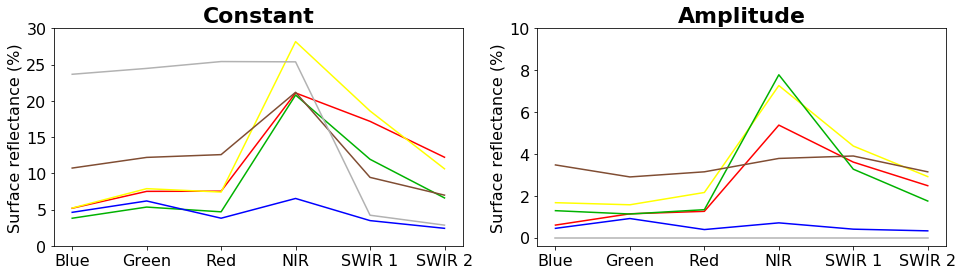

In [38]:

# computing amplitude and phase shift for each band
for band in spectral_bands:
    a = df_coefs[f'midcenter_{band}_a1']
    b = df_coefs[f'midcenter_{band}_b1']
    df_coefs[f'midcenter_{band}_amplitude1'] = np.sqrt(np.power(a,2)+np.power(b,2))
    df_coefs[f'midcenter_{band}_phase_shift1'] = np.arctan(b/a)


    
def plot_data(ax,df,label,features,title):
    
    
    bands = ['blue','green','red','nir','swir1','swir2']
    band_names = ['Blue','Green','Red','NIR','SWIR 1','SWIR 2']
    
    classes = [
        'Artifical areas',
        'Grass, herb and brush vegetation',
        'Tree vegetation',
        'Bare land',
        'Watery areas',
        'Glacier, perpetual snow'
    ]

    colors = [
        '#FF0000',
        '#FFFF00',
        '#00B200',
        '#804D33',
        '#0000FF',
        '#B2B2B2'
    ]
    
    lines = []
    classes = sorted(df[label].unique())
    
    for iclass in classes:
        
        df_sub = df[df[label]==iclass]
        class_means = [np.mean(list(df_sub[feature])) for feature in features]
        class_medians = [np.median(list(df_sub[feature])) for feature in features]
        class_medians = [median/100. for median in class_medians]
        class_stds = [np.std(list(df_sub[feature])) for feature in features]
        
        lines += ax.plot([i for i in range(len(features))], class_medians, label=iclass, color=colors[iclass])
        
    fontsize = 16
    fontsize_title = 22        
    plt.rcParams.update({'font.size': fontsize, 'axes.labelsize': fontsize, 'axes.titlesize': fontsize })
    ax.set_title(
        title,
        fontdict={'size': fontsize_title, 'weight': 'bold'}
    )
    ax.set_xticks([i for i in range(len(features))])
    ax.set_xticklabels(band_names, fontdict={'fontsize': fontsize})
    return






n_plots = 4
fig, axs = plt.subplots(1,2, figsize=(16,4), facecolor='w', edgecolor='k', sharex=True)
fontsize = 16
fontsize_title = 22   
plt.rcParams.update({'font.size': fontsize, 'axes.labelsize': fontsize, 'axes.titlesize': fontsize })
fig.subplots_adjust(hspace=0.1, wspace=0.18)
axs = axs.ravel()

plot_data(axs[0],df_coefs,'land_cover',[f'midcenter_{band}_c' for band in spectral_bands],'Constant')
plot_data(axs[1],df_coefs,'land_cover',[f'midcenter_{band}_amplitude1' for band in spectral_bands],'Amplitude')

yticks = np.arange(0,31,5)
axs[0].set_yticks(yticks)
axs[0].set_yticklabels([f'{ytick:.0f}' for ytick in yticks])
yticks = np.arange(0,11,2)
axs[1].set_yticks(yticks)
axs[1].set_yticklabels([f'{ytick:.0f}' for ytick in yticks])
axs[0].set_ylabel('Surface reflectance (%)', fontsize=fontsize)
axs[1].set_ylabel('Surface reflectance (%)', fontsize=fontsize)

plt.savefig(f'plots/reference_data_analysis_as{yearAS}.png', dpi=300, bbox_inches = "tight")
plt.show()